<a href="https://colab.research.google.com/github/Ratnesh-bhosale/Book-Recommendation-using-KNN/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.5.0


### **Load Dataset**

In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL  = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path  = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

122880/118774 [===============================] - 0s 0us/step


In [3]:
print(train_file_path)
print(test_file_path)

/root/.keras/datasets/train-data.tsv
/root/.keras/datasets/valid-data.tsv


In [4]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [5]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [6]:
print(len(df_train))
print(len(df_test))

4179
1392


### **Preprocessing**

In [7]:
# Handle categorical values
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0.5, 1.0, 'Number of ham and spam messages')

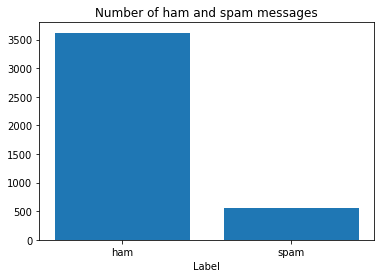

In [8]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [9]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [10]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [11]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [12]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [13]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [15]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

In [16]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [17]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [18]:
# Make all rows of equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

### **Modelling**

In [19]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________

In [21]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=1,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

27/27 [==============================] - 18s 548ms/step - loss: 0.3167 - accuracy: 0.8959 - val_loss: 0.1051 - val_accuracy: 0.9785


In [22]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
27/27 [==============================] - 14s 532ms/step - loss: 0.0874 - accuracy: 0.9815 - val_loss: 0.0981 - val_accuracy: 0.9880


### **Evaluate**

In [23]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [24]:
s = model.evaluate(preprocessing(df_test['x']), y_test)

44/44 [==============================] - 2s 56ms/step - loss: 0.0843 - accuracy: 0.9828


In [25]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.084, Accuracy: 0.983


### **Predict**

In [33]:
# function to predict messages based on model
# return list containing prediction and label, ex. [0.008318834938108921, 'ham']
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

In [36]:
pred_text = "our new mobile video service is live. just install on your phone to start watching."

prediction = predict_message(pred_text)
print(prediction)

(0.9351675, 'spam')


In [40]:
for i in range(4):
  message = input("Write the message: ")
  print("Prediction: This message is {} ({}) \n".format(predict_message(message)[1],predict_message(message)[0]))

Write the message: Hey how are you doing?
Prediction: This message is ham (0.0) 

Write the message: you have won £1000 cash! call to claim your prize.
Prediction: This message is spam (1.0179940462112427) 

Write the message: our new mobile video service is live. just install on your phone to start watching.
Prediction: This message is spam (0.9351674914360046) 

Write the message: Hello have you attended today's lecture?
Prediction: This message is ham (0.0) 

